<a href="https://colab.research.google.com/github/lili0706/CE6068_Final_Project/blob/main/method2%3AVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = 'AODB_antio_peptides.csv'
df = pd.read_csv(file_path)

print("原始資料前五行：")
print(df.head())
print("\n資料欄位：")
print(df.columns)

原始資料前五行：
     aox_id sequence                   amino_acid  length  \
0  AOPE0001      AHK                  Ala-His-Lys       3   
1  AOPE0002      VHH                  Val-His-His       3   
2  AOPE0003  VHHANEN  Val-His-His-Ala-Asn-Glu-Asn       7   
3  AOPE0004       HK                      His-Lys       2   
4  AOPE0005       AH                      Ala-His       2   

                             source  \
0  Egg White Albumin, Egg Ovalbumin   
1  Egg White Albumin, Egg Ovalbumin   
2  Egg White Albumin, Egg Ovalbumin   
3                 Egg White Albumin   
4                 Egg White Albumin   

                                antioxidant_activity chemical_formula  \
0  Antioxidative activity was evaluated by the fe...       C15H26N6O4   
1  Antioxidative activity was evaluated by the fe...       C17H25N7O4   
2  Antioxidative activity was evaluated by the fe...     C33H49N13O12   
3  Antioxidative activity was evaluated by the fe...       C12H21N5O3   
4  Antioxidative activit

In [ ]:
# 確保 'sequence' 欄位存在且是字串類型
if 'sequence' not in df.columns:
    raise ValueError("資料中缺少 'sequence' 欄位，請檢查資料結構。")

# 篩選指定長度的序列
selected_lengths = [3, 4, 5, 6]
df_cleaned = df.dropna(subset=['sequence']) # 刪除 sequence 欄位為 NaN 的行
df_filtered = df_cleaned[df_cleaned['sequence'].astype(str).apply(lambda x: len(x) in selected_lengths)].copy()

print(f"\n篩選後長度為 {selected_lengths} 的資料：")
print(df_filtered.head())
print("\n檢查 df_filtered 中是否有 NaN 或非預期序列：")
print(df_filtered['sequence'].value_counts(dropna=False).head(10)) # 看看有沒有 NaN 或其他奇怪的字符串
print(f"df_filtered 中有多少 NaN 序列：{df_filtered['sequence'].isnull().sum()}")
print(f"篩選後資料筆數：{len(df_filtered)}")

# 提取所需的欄位
aox_data = df_filtered[['sequence', 'aox_id', 'source']].copy()
print("\n用於模型的資料預覽：")
print(aox_data.head())


篩選後長度為 [3, 4, 5, 6] 的資料：
     aox_id sequence               amino_acid  length  \
0  AOPE0001      AHK              Ala-His-Lys       3   
1  AOPE0002      VHH              Val-His-His       3   
5  AOPE0006    MQFHT      Met-Gln-Phe-His-Thr       5   
6  AOPE0007   PHCKRM  Pro-His-Cys-Lys-Arg-Met       6   
9  AOPE0010    LLPHH      Leu-Leu-Pro-His-His       5   

                             source  \
0  Egg White Albumin, Egg Ovalbumin   
1  Egg White Albumin, Egg Ovalbumin   
5                 Synthetic Peptide   
6                 Synthetic Peptide   
9                   Soybean Protein   

                                antioxidant_activity chemical_formula  \
0  Antioxidative activity was evaluated by the fe...       C15H26N6O4   
1  Antioxidative activity was evaluated by the fe...       C17H25N7O4   
5                                                  -      C29H42N8O8S   
6                                                  -    C31H54N12O7S2   
9                              

In [ ]:
import re

# 將所有序列轉換為大寫，並移除任何非大寫字母（即非胺基酸）字符
aox_data['sequence'] = aox_data['sequence'].astype(str).apply(lambda s: re.sub(r'[^A-Z]', '', s.upper()))

# 提取所有獨特胺基酸
all_sequences_for_vocab = aox_data['sequence'].tolist() # 已經是 str 了
amino_acids = sorted(list(set(''.join(all_sequences_for_vocab))))

# 在這裡檢查並移除空序列
original_data_len = len(aox_data)
aox_data = aox_data[aox_data['sequence'].apply(len) > 0]
if len(aox_data) < original_data_len:
    print(f"警告：清洗後移除了 {original_data_len - len(aox_data)} 個空序列。")

# 這裡將 'PAD' 設定為索引 0
vocab = ['PAD'] + amino_acids
vocab_size = len(vocab)
aa_to_int = {aa: i for i, aa in enumerate(vocab)}
int_to_aa = {i: aa for aa, i in aa_to_int.items()}

print(f"\n胺基酸詞彙表 (vocab_size={vocab_size}): {vocab}")


胺基酸詞彙表 (vocab_size=21): ['PAD', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# 設定最大序列長度
max_seq_len_in_data = max(aox_data['sequence'].astype(str).apply(len))
seq_len = 6
# print(f"設定的序列最大長度 (seq_len): {seq_len}")

# 序列編碼函數
def encode_sequence(sequence, aa_to_int, max_len):
    encoded = [aa_to_int.get(aa, aa_to_int['PAD']) for aa in sequence]
    # Padding
    if len(encoded) < max_len:
        encoded.extend([aa_to_int['PAD']] * (max_len - len(encoded)))
    return encoded[:max_len]

# 解碼函數 (用於可視化結果)
def decode_sequence(encoded_sequence, int_to_aa, padding_idx=0):
    return ''.join([int_to_aa[idx] for idx in encoded_sequence if idx != padding_idx])

# 對所有序列進行編碼
encoded_sequences = [encode_sequence(str(s), aa_to_int, seq_len) for s in aox_data['sequence']]
X_tensor = torch.tensor(encoded_sequences, dtype=torch.long)

print(f"\n編碼後的序列張量形狀：{X_tensor.shape}")
# print("編碼後序列範例：")
# print(X_tensor[0])
# print(f"解碼回原序列：{decode_sequence(X_tensor[0].tolist(), int_to_aa)}")

# 檢查編碼後的張量中是否存在越界索引
max_val_in_tensor = torch.max(X_tensor).item()
min_val_in_tensor = torch.min(X_tensor).item()
print(f"X_tensor 中最大索引值: {max_val_in_tensor}")
print(f"X_tensor 中最小索引值: {min_val_in_tensor}")

if max_val_in_tensor >= vocab_size:
    print(f"!!! CRITICAL ERROR: Max index in X_tensor ({max_val_in_tensor}) is >= vocab_size ({vocab_size}).")
    print("這意味著在編碼過程中產生了超出 Embedding 層有效範圍的索引。")
    print("請檢查您的原始數據是否有未知字符，或 vocab_size 是否正確計算。")

    raise ValueError("Index out of range detected in encoded data after processing!")


# PyTorch Dataset 和 DataLoader
class PeptideDataset(Dataset):
    def __init__(self, sequences_tensor):
        self.sequences = sequences_tensor

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

dataset = PeptideDataset(X_tensor)

# 訓練集和驗證集劃分
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

batch_size = 2 #

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"\n訓練集大小: {len(train_dataset)}")
print(f"驗證集大小: {len(val_dataset)}")
print(f"訓練批次數: {len(train_loader)}")
print(f"驗證批次數: {len(val_loader)}")


胺基酸詞彙表 (vocab_size=21): ['PAD', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
設定的序列最大長度 (seq_len): 6

編碼後的序列張量形狀：torch.Size([883, 6])
編碼後序列範例：
tensor([1, 7, 9, 0, 0, 0])
解碼回原序列：AHK
X_tensor 中最大索引值: 20
X_tensor 中最小索引值: 0

訓練集大小: 706
驗證集大小: 177
訓練批次數: 353
驗證批次數: 89


In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
def vae_seq_loss_fn(logits, x, mu, logvar, beta=0.001, free_bits=0.0, class_weights=None):
    # 傳入 class_weights 參數
    if class_weights is not None:
        recon_loss = nn.CrossEntropyLoss(ignore_index=0, weight=class_weights)(
            logits.view(-1, logits.size(-1)), # (batch_size * seq_len, vocab_size)
            x.view(-1) # (batch_size * seq_len)
        )
    else:
        # 如果沒有提供權重，則使用標準的 CrossEntropyLoss
        recon_loss = nn.CrossEntropyLoss(ignore_index=0)(
            logits.view(-1, logits.size(-1)),
            x.view(-1)
        )

    # KL 散度計算
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Free Bits
    kl_div_penalized = torch.max(kl_div, torch.tensor(free_bits).to(kl_div.device))

    return recon_loss + beta * kl_div_penalized, recon_loss.item(), kl_div.item()

class VAE_seq_CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim, hidden_channels=64, seq_len=6):
        super(VAE_seq_CNN, self).__init__()
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.hidden_channels = hidden_channels

        # Embedding 層的 vocab_size 必須與實際數據中的最大索引+1 匹配
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Encoder: 使用 Conv1d
        # 輸入: (batch_size, embed_dim, seq_len)
        self.encoder_conv = nn.Sequential(
            nn.Conv1d(embed_dim, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1) # 將序列維度池化為 1，得到固定大小的特徵向量 (batch_size, hidden_channels * 2, 1)
        )
        # 展平後的維度
        self.encoder_output_dim = hidden_channels * 2 * 1

        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_dim, latent_dim)
        self.decoder_output_fc = nn.Linear(latent_dim, seq_len * embed_dim)

        # 最終輸出到 vocab_size 的層 (每個時間步的 logits)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def encode(self, x):
        x_embed = self.embedding(x) # (batch, seq_len, embed_dim)

        x_embed = x_embed.permute(0, 2, 1) # 轉換為 (batch, embed_dim, seq_len)

        h = self.encoder_conv(x_embed) # (batch, hidden_channels * 2, 1)

        h = h.view(h.size(0), -1) # 展平為 (batch, hidden_channels * 2)


        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):

        # Map latent vector directly to the flattened sequence embedding size
        decoded_flat_features = self.decoder_output_fc(z) # (batch, seq_len * embed_dim)

        # Reshape to (batch, seq_len, embed_dim)
        decoded_features = decoded_flat_features.view(decoded_flat_features.size(0), self.seq_len, self.embed_dim)

        logits = self.output_layer(decoded_features) # (batch, seq_len, vocab_size)

        return logits

    def forward(self, x):
        mu, logvar = self.encode(x)

        logvar = torch.clamp(logvar, min=-10.0, max=0.0)

        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

# 模型初始化參數
embed_dim = 32 # 調整嵌入維度
latent_dim = 20 # 潛在空間維度
hidden_channels = 32 # CNN 的隱藏通道數

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 實例化模型
model = VAE_seq_CNN(vocab_size=vocab_size, embed_dim=embed_dim, latent_dim=latent_dim, hidden_channels=hidden_channels, seq_len=seq_len).to(device)

# 初始化優化器
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5) # 示例值

print("\n模型架構：")
print(model)


模型架構：
VAE_seq_CNN(
  (embedding): Embedding(21, 32, padding_idx=0)
  (encoder_conv): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): AdaptiveMaxPool1d(output_size=1)
  )
  (fc_mu): Linear(in_features=64, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=64, out_features=20, bias=True)
  (decoder_output_fc): Linear(in_features=20, out_features=192, bias=True)
  (output_layer): Linear(in_features=32, out_features=21, bias=True)
)


In [ ]:
# 訓練參數
epochs = 1000 # 可以根據收斂情況調整
anneal_start_epoch = 0
anneal_end_epoch = 50 # 讓 beta 在前 50 個 epoch 逐漸增加
max_beta = 0.01 # KL 散度權重，對較短序列可以嘗試較小的 beta
current_free_bits = 0.2 # 這裡設置一個初始值

clip_norm_value = 1.0 # 梯度裁剪值

train_losses, val_losses, kl_divs = [], [], []

print("\n--- 開始訓練 ---")
for epoch in range(epochs):
    model.train()
    total_loss, total_kl, total_recon_loss = 0, 0, 0

    # 在訓練循環的每個 epoch 開始時
    if epoch < anneal_end_epoch:
        current_beta = max_beta * (epoch / max(1, anneal_end_epoch))
    else:
        current_beta = max_beta

    # 確保在訓練過程中，即使 KL 散度很小，也至少有一個小的值以避免訓練問題
    if current_beta == 0 and epoch >= anneal_start_epoch:
        current_beta = 1e-5 # 設置一個非常小的非零值

    print(f"\n--- Epoch {epoch+1}/{epochs}, Current Beta: {current_beta:.6f}, Free Bits: {current_free_bits:.4f} ---")

    for i, batch_data in enumerate(train_loader):
        x = batch_data.to(device) # 現在每個 batch 只有序列本身

        optimizer.zero_grad() # 在計算損失之前清零梯度

        logits, mu, logvar = model(x)

        # 計算損失
        loss, recon_l, kl = vae_seq_loss_fn(
            logits, x, mu, logvar,
            beta=current_beta,
            free_bits=current_free_bits,
        )

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm_value)

        optimizer.step()

        total_loss += loss.item()
        total_kl += kl
        total_recon_loss += recon_l

        if i == 0:
            # print(f"  Batch {i}:")
            # print(f"    Input batch shape: {x.shape}")
            # print(f"    Logits shape: {logits.shape}")
            print(f"    mu stats:     min={mu.min().item():.4f}, max={mu.max().item():.4f}, mean={mu.mean().item():.4f}, std={mu.std().item():.4f}")
            print(f"    logvar stats: min={logvar.min().item():.4f}, max={logvar.max().item():.4f}, mean={logvar.mean().item():.4f}, std={logvar.std().item():.4f}")


    # 計算平均訓練損失和 KL 散度
    train_losses.append(total_loss / len(train_loader))
    kl_divs.append(total_kl / len(train_loader))

    # 驗證集評估
    model.eval()
    val_total_loss = 0
    val_recon_loss_sum = 0
    val_kl_div_sum = 0

    with torch.no_grad():
        for batch_data in val_loader:
            x = batch_data.to(device)
            logits, mu, logvar = model(x)

            loss, recon_loss_item, kl_div_item = vae_seq_loss_fn(
                logits, x, mu, logvar,
                beta=current_beta,
                free_bits=current_free_bits,
            )
            val_total_loss += loss.item()
            val_recon_loss_sum += recon_loss_item
            val_kl_div_sum += kl_div_item

    # 計算平均損失
    avg_val_total_loss = val_total_loss / len(val_loader)
    avg_val_recon_loss = val_recon_loss_sum / len(val_loader)
    avg_val_kl_div = val_kl_div_sum / len(val_loader)

    # 將平均損失添加到列表中以供繪圖或未來使用
    val_losses.append(avg_val_total_loss)

    print(f"Epoch {epoch+1} Summary: Train Total Loss: {train_losses[-1]:.4f}, Train Recon Loss: {total_recon_loss / len(train_loader):.4f}, Val Total Loss: {avg_val_total_loss:.4f}, Val Recon Loss: {avg_val_recon_loss:.4f}, KL Div: {avg_val_kl_div:.4f}")

print("\n--- 訓練完成！ ---")

串流輸出內容已截斷至最後 5000 行。

--- Epoch 376/1000, Current Beta: 0.010000, Free Bits: 0.2000 ---
  Batch 0:
    Input batch shape: torch.Size([2, 6])
    Logits shape: torch.Size([2, 6, 21])
    mu stats:     min=-2.1423, max=2.2306, mean=0.3241, std=1.0466
    logvar stats: min=-2.7310, max=-1.4732, mean=-2.0494, std=0.2651
Epoch 376 Summary: Train Total Loss: 0.0218, Train Recon Loss: 0.0074, Val Total Loss: 0.9125, Val Recon Loss: 0.8991, KL Div: 1.3450

--- Epoch 377/1000, Current Beta: 0.010000, Free Bits: 0.2000 ---
  Batch 0:
    Input batch shape: torch.Size([2, 6])
    Logits shape: torch.Size([2, 6, 21])
    mu stats:     min=-2.5954, max=2.1303, mean=0.1797, std=1.4282
    logvar stats: min=-3.8058, max=-1.7569, mean=-2.7273, std=0.4592
Epoch 377 Summary: Train Total Loss: 0.0238, Train Recon Loss: 0.0092, Val Total Loss: 0.8320, Val Recon Loss: 0.8182, KL Div: 1.3721

--- Epoch 378/1000, Current Beta: 0.010000, Free Bits: 0.2000 ---
  Batch 0:
    Input batch shape: torch.Size([2, 6

FileNotFoundError: [Errno 2] No such file or directory: 'best_vae_model.pt'

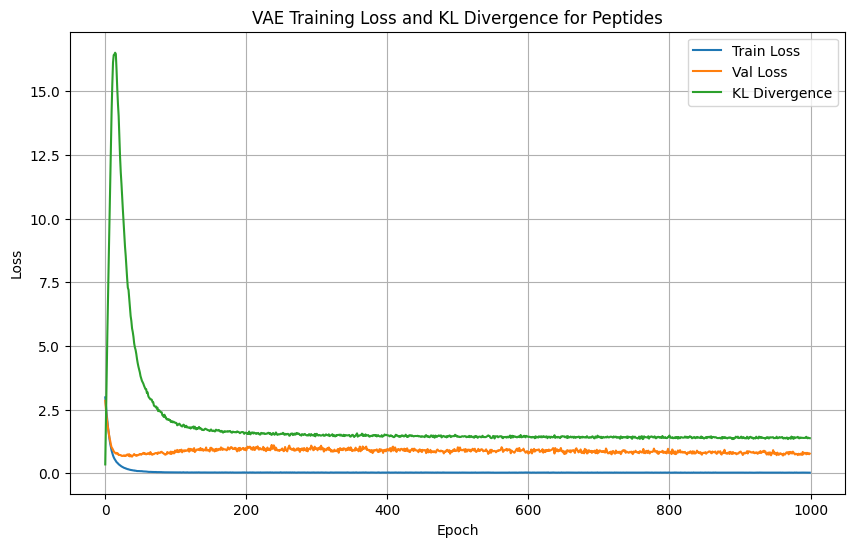

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(kl_divs, label="KL Divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss and KL Divergence for Peptides")
plt.grid(True)
plt.show()


Real data latent feature matrix shape: (883, 20)
Generated data latent feature matrix shape: (883, 20)


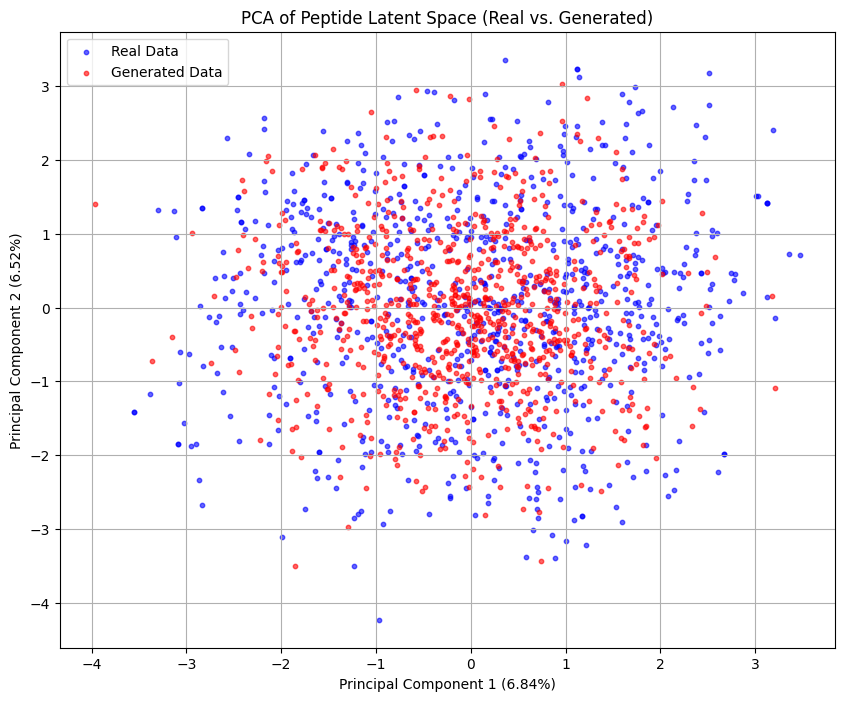

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


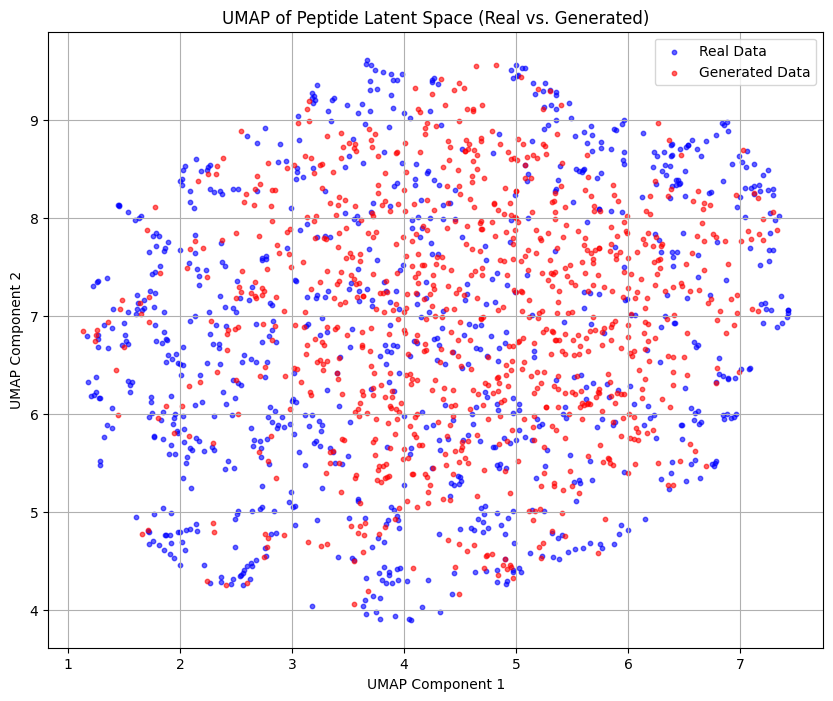

In [ ]:
model.eval()

all_real_latents = []
all_real_sequences = []

with torch.no_grad():

    for batch_data in train_loader:
        x = batch_data.to(device)
        mu, _ = model.encode(x)
        all_real_latents.append(mu.cpu().numpy())
        all_real_sequences.append(x.cpu().numpy())

    for batch_data in val_loader:
        x = batch_data.to(device)
        mu, _ = model.encode(x)
        all_real_latents.append(mu.cpu().numpy())
        all_real_sequences.append(x.cpu().numpy())

real_latent_matrix = np.vstack(all_real_latents)
real_sequence_matrix = np.vstack(all_real_sequences)

print("\nReal data latent feature matrix shape:", real_latent_matrix.shape)

num_generated_samples = real_latent_matrix.shape[0] # 生成與真實數據相同數量的樣本

if hasattr(model, 'latent_dim'):
    latent_dim = model.latent_dim
else:
    print("Warning: model.latent_dim not found. Assuming latent_dim = 64 for generation. Please adjust if different.")
    latent_dim = 64

z = torch.randn(num_generated_samples, latent_dim).to(device)

generated_latent_matrix = z.cpu().numpy()

print("Generated data latent feature matrix shape:", generated_latent_matrix.shape)

combined_latents = np.vstack((real_latent_matrix, generated_latent_matrix))

labels = np.array([0] * real_latent_matrix.shape[0] + [1] * generated_latent_matrix.shape[0])

# --- PCA 可視化 ---
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined_latents)

plt.figure(figsize=(10, 8))
# 繪製真實數據點
plt.scatter(combined_pca[labels == 0, 0], combined_pca[labels == 0, 1],
            alpha=0.6, s=10, label='Real Data', color='blue')
# 繪製生成數據點
plt.scatter(combined_pca[labels == 1, 0], combined_pca[labels == 1, 1],
            alpha=0.6, s=10, label='Generated Data', color='red')

plt.title("PCA of Peptide Latent Space (Real vs. Generated)")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.grid(True)
plt.legend()
plt.show()

# --- UMAP 可視化 ---
reducer = umap.UMAP(random_state=42)
combined_umap = reducer.fit_transform(combined_latents)

plt.figure(figsize=(10, 8))
# 繪製真實數據點
plt.scatter(combined_umap[labels == 0, 0], combined_umap[labels == 0, 1],
            alpha=0.6, s=10, label='Real Data', color='blue')
# 繪製生成數據點
plt.scatter(combined_umap[labels == 1, 0], combined_umap[labels == 1, 1],
            alpha=0.6, s=10, label='Generated Data', color='red')

plt.title("UMAP of Peptide Latent Space (Real vs. Generated)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model.eval()
reconstruction_losses = []
all_original_sequences = []

with torch.no_grad():

    full_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for batch_data in full_data_loader:
        x = batch_data.to(device)
        recon_logits, mu, logvar = model(x)
        recon_loss_fn = nn.CrossEntropyLoss(reduction='none', ignore_index=0)
        element_loss = recon_loss_fn(recon_logits.view(-1, recon_logits.size(-1)), x.view(-1)) # shape (batch_size * seq_len,)

        # Reshape element-wise loss back to (batch_size, seq_len)
        element_loss = element_loss.view(x.size(0), x.size(1))

        mask = (x != 0).float()
        seq_loss = (element_loss * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9)
        seq_loss[mask.sum(dim=1) == 0] = 0

        reconstruction_losses.extend(seq_loss.cpu().numpy())
        all_original_sequences.extend(x.cpu().numpy())

reconstruction_losses = np.array(reconstruction_losses)
all_original_sequences = np.array(all_original_sequences)

N = 10
top_indices = np.argsort(reconstruction_losses)[-N:][::-1]  # 取前 N 個最大誤差的序列索引

print("\n--- 重建誤差分析 ---")
print(f"重建誤差最大的前 {N} 個序列：")
for idx in top_indices:
    seq_indices = all_original_sequences[idx]
    error = reconstruction_losses[idx]
    original_peptide = decode_sequence(seq_indices.tolist(), int_to_aa) # 解碼回胺基酸序列

    # 同時重建序列看看
    with torch.no_grad():
        input_seq_tensor = torch.tensor(seq_indices, dtype=torch.long).unsqueeze(0).to(device)
        recon_logits, _, _ = model(input_seq_tensor)
        # 取得預測的 token ID
        predicted_indices = torch.argmax(recon_logits, dim=-1).squeeze(0).cpu().numpy()
        reconstructed_peptide = decode_sequence(predicted_indices.tolist(), int_to_aa)

    print(f"索引: {idx}, 重建誤差: {error:.4f}")
    print(f"  原始序列: '{original_peptide}' (索引: {seq_indices})")
    print(f"  重建序列: '{reconstructed_peptide}' (索引: {predicted_indices})")
    print("-" * 30)


--- 重建誤差分析 ---
重建誤差最大的前 10 個序列：
索引: 510, 重建誤差: 7.9422
  原始序列: 'MPDAHL' (索引: [11 13  3  1  7 10])
  重建序列: 'MHHHYS' (索引: [11  7  7  7 20 16])
------------------------------
索引: 282, 重建誤差: 7.4230
  原始序列: 'LLNPT' (索引: [10 10 12 13 17  0])
  重建序列: 'LLNHVH' (索引: [10 10 12  7 18  7])
------------------------------
索引: 281, 重建誤差: 5.2714
  原始序列: 'PLAQPA' (索引: [13 10  1 14 13  1])
  重建序列: 'PLAQVE' (索引: [13 10  1 14 18  4])
------------------------------
索引: 324, 重建誤差: 5.2674
  原始序列: 'HVCYMF' (索引: [ 7 18  2 20 11  5])
  重建序列: 'GVESRP' (索引: [ 6 18  4 16 15 13])
------------------------------
索引: 769, 重建誤差: 4.8703
  原始序列: 'FMPLH' (索引: [ 5 11 13 10  7  0])
  重建序列: 'FMPLPH' (索引: [ 5 11 13 10 13  7])
------------------------------
索引: 60, 重建誤差: 4.7773
  原始序列: 'AEFAES' (索引: [ 1  4  5  1  4 16])
  重建序列: 'AEFEPE' (索引: [ 1  4  5  4 13  4])
------------------------------
索引: 486, 重建誤差: 4.5907
  原始序列: 'VVVVPH' (索引: [18 18 18 18 13  7])
  重建序列: 'VVVVQR' (索引: [18 18 18 18 14 15])
----------------------------

In [ ]:
def generate_sequences(model, num_samples, latent_dim, seq_len, int_to_aa, device, padding_idx=0):
    model.eval()
    generated_peptides = []
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        logits = model.decode(z) # (num_samples, seq_len, vocab_size)

        # 將 logits 轉換為最可能的 token ID
        predicted_indices = torch.argmax(logits, dim=-1).cpu().numpy()

        for seq_indices in predicted_indices:
            generated_peptides.append(decode_sequence(seq_indices.tolist(), int_to_aa, padding_idx))
    return generated_peptides

print("\n--- 生成新的胜肽序列 ---")
num_generated_peptides = 20
generated_peptides = generate_sequences(model, num_generated_peptides, latent_dim, seq_len, int_to_aa, device)

for i, peptide in enumerate(generated_peptides):
    print(f"生成胜肽 {i+1}: '{peptide}' (長度: {len(peptide)})")

generated_lengths = [len(p) for p in generated_peptides]
print(f"\n生成序列長度分佈：{pd.Series(generated_lengths).value_counts().sort_index()}")


--- 生成新的胜肽序列 ---
生成胜肽 1: 'YGWIQK' (長度: 6)
生成胜肽 2: 'EDQWVR' (長度: 6)
生成胜肽 3: 'IAQAPS' (長度: 6)
生成胜肽 4: 'YELEKH' (長度: 6)
生成胜肽 5: 'NHWVHP' (長度: 6)
生成胜肽 6: 'MELSFE' (長度: 6)
生成胜肽 7: 'RDKPKM' (長度: 6)
生成胜肽 8: 'VQWHQY' (長度: 6)
生成胜肽 9: 'PNHKIQ' (長度: 6)
生成胜肽 10: 'FKGYPE' (長度: 6)
生成胜肽 11: 'AEHATY' (長度: 6)
生成胜肽 12: 'YYDIEW' (長度: 6)
生成胜肽 13: 'EAVIVQ' (長度: 6)
生成胜肽 14: 'ILIHQV' (長度: 6)
生成胜肽 15: 'IPWDVS' (長度: 6)
生成胜肽 16: 'IEGNMQ' (長度: 6)
生成胜肽 17: 'NQAVEA' (長度: 6)
生成胜肽 18: 'VLHGHH' (長度: 6)
生成胜肽 19: 'WLRKPM' (長度: 6)
生成胜肽 20: 'SYEFFM' (長度: 6)

生成序列長度分佈：6    20
Name: count, dtype: int64


In [ ]:
for i in generated_peptides:
    print(i)

YGWIQK
EDQWVR
IAQAPS
YELEKH
NHWVHP
MELSFE
RDKPKM
VQWHQY
PNHKIQ
FKGYPE
AEHATY
YYDIEW
EAVIVQ
ILIHQV
IPWDVS
IEGNMQ
NQAVEA
VLHGHH
WLRKPM
SYEFFM



--- 胺基酸分佈分析 ---

原始序列胺基酸分佈：
  A: 0.0563
  C: 0.0146
  D: 0.0373
  E: 0.0528
  F: 0.0471
  G: 0.0563
  H: 0.0675
  I: 0.0399
  K: 0.0462
  L: 0.0994
  M: 0.0247
  N: 0.0250
  P: 0.0922
  Q: 0.0362
  R: 0.0370
  S: 0.0373
  T: 0.0302
  V: 0.0514
  W: 0.0485
  Y: 0.0999

生成 10000 條序列後的胺基酸分佈：
  A: 0.0564
  C: 0.0118
  D: 0.0386
  E: 0.0594
  F: 0.0570
  G: 0.0374
  H: 0.0659
  I: 0.0389
  K: 0.0590
  L: 0.0761
  M: 0.0366
  N: 0.0357
  P: 0.0924
  Q: 0.0498
  R: 0.0369
  S: 0.0368
  T: 0.0324
  V: 0.0440
  W: 0.0467
  Y: 0.0882


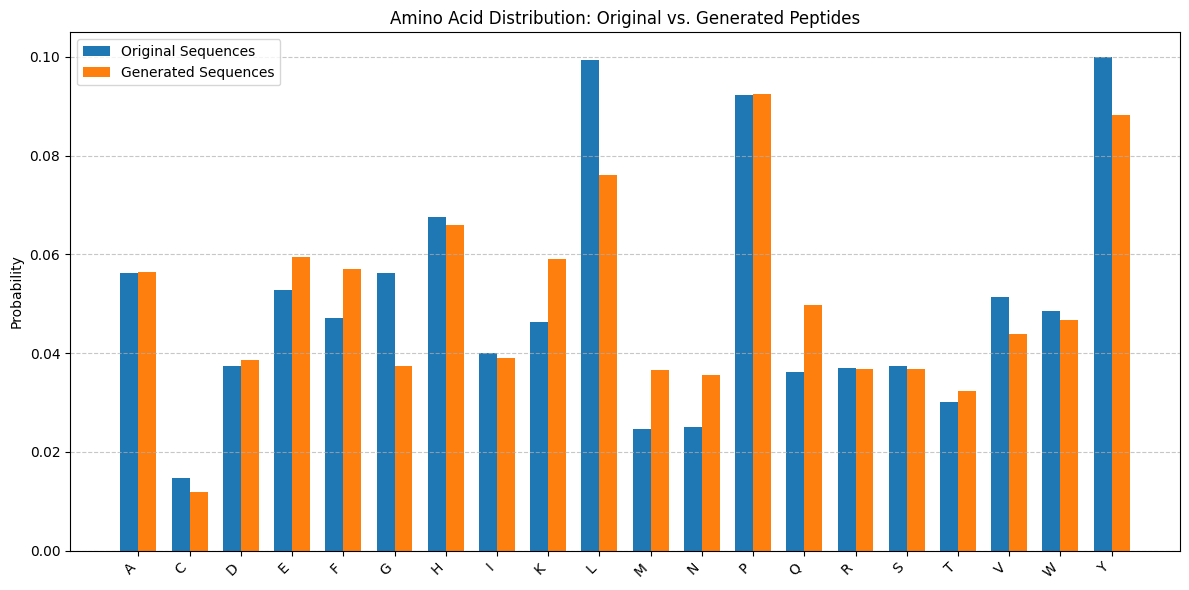

In [ ]:
padding_idx = 0

print("\n--- 胺基酸分佈分析 ---")

# 1. 計算原始訓練數據中每個胺基酸的頻率分佈
original_aa_counts = {}
total_original_aa = 0

# 遍歷所有原始序列（使用完整的 dataset，不限於訓練集或驗證集）
full_data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
for batch_data in full_data_loader:
    x = batch_data.cpu().numpy()
    for seq_indices in x:
        for idx in seq_indices:
            if idx != padding_idx: # 忽略 padding 字符
                aa = int_to_aa[idx]
                original_aa_counts[aa] = original_aa_counts.get(aa, 0) + 1
                total_original_aa += 1

original_aa_distribution = {aa: count / total_original_aa for aa, count in original_aa_counts.items()}
print("\n原始序列胺基酸分佈：")

sorted_original_dist = sorted(original_aa_distribution.items())
for aa, prob in sorted_original_dist:
    print(f"  {aa}: {prob:.4f}")

# 生成大量新序列並計算其胺基酸分佈
num_generated_for_analysis = 10000
generated_peptides_for_analysis = generate_sequences(model, num_generated_for_analysis, latent_dim, seq_len, int_to_aa, device, padding_idx)

generated_aa_counts = {}
total_generated_aa = 0

for peptide in generated_peptides_for_analysis:
    for aa in peptide:
        generated_aa_counts[aa] = generated_aa_counts.get(aa, 0) + 1
        total_generated_aa += 1

for aa_char in aa_to_int:
    if aa_char != 'PAD' and aa_char not in generated_aa_counts:
        generated_aa_counts[aa_char] = 0


generated_aa_distribution = {aa: count / total_generated_aa if total_generated_aa > 0 else 0 for aa, count in generated_aa_counts.items()}
print(f"\n生成 {num_generated_for_analysis} 條序列後的胺基酸分佈：")
sorted_generated_dist = sorted(generated_aa_distribution.items())
for aa, prob in sorted_generated_dist:
    print(f"  {aa}: {prob:.4f}")

# 3. 可視化比較
amino_acids_to_plot = sorted([aa for aa in aa_to_int if aa != 'PAD'])

original_probs = [original_aa_distribution.get(aa, 0) for aa in amino_acids_to_plot]
generated_probs = [generated_aa_distribution.get(aa, 0) for aa in amino_acids_to_plot]

x = np.arange(len(amino_acids_to_plot))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, original_probs, width, label='Original Sequences')
rects2 = ax.bar(x + width/2, generated_probs, width, label='Generated Sequences')


ax.set_ylabel('Probability')
ax.set_title('Amino Acid Distribution: Original vs. Generated Peptides')
ax.set_xticks(x)
ax.set_xticklabels(amino_acids_to_plot, rotation=45, ha="right")
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
